In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import numpy as np
import sklearn as skl
from sklearn import preprocessing
from sklearn import model_selection
import matplotlib.pyplot as plt

from training_functions import summarize_data, get_encoded_labels_overshoot_undershoot_classification

In [2]:
# Load data
dataset = pd.read_csv("../Datasets/Three Coefficient System Data.csv")
print(dataset.head())
summarize_data(dataset)

         D1         N2         N1   RiseTime  TransientTime  SettlingTime  \
0 -7.792284   5.479346   6.716621   1.387282       2.590738      2.610738   
1 -8.421525   5.120316   0.353875  31.358374      56.150816     56.150816   
2 -7.190644   7.520692  12.880123   0.977723       1.865514      1.892572   
3 -0.999792   3.934565   3.444088   1.817707       3.844851      4.141904   
4  3.242414  14.304431  50.128112   0.090039       0.798297      0.798297   

   SettlingMin  SettlingMax  Overshoot  Undershoot       Peak    PeakTime  
0    -1.160146    -1.046628   0.000000    3.758780   1.160146    7.437680  
1   -23.781914   -21.474148   0.000000   -0.000000  23.781914  104.497226  
2    -0.557838    -0.502913   0.000000    7.321072   0.557838    3.125033  
3    -0.289938    -0.261309   0.000000   47.523859   0.289938    6.270974  
4     0.058454     0.076270  17.914613   -0.000000   0.076270    0.262541  
Models with overshoot: 1613/16.13%
Models with undershoot: 4846/48.46%
Models wit

In [3]:
# Determine the appropriate label for each entry using one-hot encoding
# [0 0 1] for undershoot, [0 1 0] for overshoot, [1 0 0] for neither
labels = get_encoded_labels_overshoot_undershoot_classification(dataset)
print(labels[0:10])

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]


In [5]:
# Convert to numpy array
data_array = dataset.to_numpy()

# Separate the coefficients, which form the inputs to the neural network, from the rest of the data
# The coefficients are the first columns in the CSV file
coefficients = data_array[:,0:3]
# Use StandardScaler to remove the mean and scale to unit variance
scaler = preprocessing.StandardScaler().fit(coefficients)
scaled_coefficients = scaler.transform(coefficients)

print(scaled_coefficients[0:10,:])
print(scaled_coefficients.shape)

[[-1.34584063 -1.11996452 -0.83356975]
 [-1.45478893 -1.20839967 -1.12254131]
 [-1.24167124 -0.61714634 -0.55364703]
 [-0.16977259 -1.50047024 -0.98219569]
 [ 0.56473283  1.05380377  1.13801428]
 [ 0.23490035 -1.96774514 -1.12332367]
 [-0.61079546 -0.40000369 -0.67081313]
 [-0.14604934 -1.02966069 -0.93830241]
 [ 0.41559378  1.06575274  1.19882136]
 [ 0.49370097  0.42974474 -0.2502778 ]]
(10000, 3)


In [13]:
# Reserve 10% of the data as test data, and use the rest as training data
train_inputs,test_inputs,train_labels,test_labels = model_selection.train_test_split(scaled_coefficients, labels, test_size=0.10)
print(train_inputs.shape, train_labels.shape,test_inputs.shape, test_labels.shape)

(9000, 3) (9000, 3) (1000, 3) (1000, 3)


In [14]:
# Use a sequential model for classification
model = tf.keras.models.Sequential()
# First hidden layer: 128 nodes, RELU activation function
model.add(keras.layers.Dense(128,
                             input_shape=(3,),
                              name='layer_1',
                              activation='relu'))
# Second hidden layer: 128 nodes, RELU activation function
model.add(keras.layers.Dense(128,
                              name='layer_2',
                              activation='relu'))
# Output layer: softmax activation function
model.add(keras.layers.Dense(3,
                             name='output_layer',
                             activation='softmax'))

model.compile(loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer_1 (Dense)             (None, 128)               512       
                                                                 
 layer_2 (Dense)             (None, 128)               16512     
                                                                 
 output_layer (Dense)        (None, 3)                 387       
                                                                 
Total params: 17,411
Trainable params: 17,411
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
450/450 [==============================] - 1s 1ms/step - loss: 0.2373 - accuracy: 0.9251 - val_loss: 0.1404 - val_accuracy: 0.9611
Epoch 2/10
450/450 [==============================] - 0s 764us/step - loss: 0.1113 - accuracy: 0.9611 - val_loss: 0.1017 - val_accuracy: 0.9617
Epoch 3/10
450/450 [==============================] - 0s 773us/step - loss: 0.0940 - accuracy: 0.9646 - val_loss: 0.0771 - val_accuracy: 0.9672
Epoch 4/10
450/450 [==============================] - 0s 751us/step - loss: 0.0817 - accuracy: 0.9681 - val_loss: 0.0815 - val_accuracy: 0.9678
Epoch 5/10
450/450 [==============================] - 0s 741us/step - loss: 0.0790 - accuracy: 0.9685 - val_loss: 0.0983 - val_accuracy: 0.9517
Epoch 6/10
450/450 [==============================] - 0s 765us/step - loss: 0.0754 - accuracy: 0.9697 - val_loss: 0.0654 - val_accuracy: 0.9711
Epoch 7/10
450/450 [==============================] - 0s 783us/step - loss: 0.0737 - accuracy: 0.9697 - val_loss: 0.0728 - val_accuracy: 0

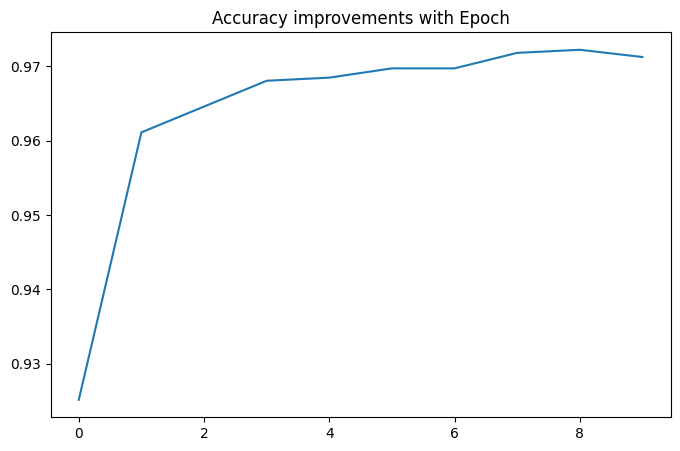


Evaluation against Test Dataset :
------------------------------------
32/32 [==============================] - 0s 802us/step - loss: 0.0620 - accuracy: 0.9730


[0.06202654540538788, 0.9729999899864197]

In [15]:
# Perform training

history=model.fit(train_inputs,
          train_labels,
          batch_size = 16,
          epochs = 10,
          verbose = 1,
          validation_split = 0.2)

# Code borrowed from Kumaran Ponnambalam's LinkedIn Learning course
# Check the accuracy after each epoch
pd.DataFrame(history.history)["accuracy"].plot(figsize=(8, 5))
plt.title("Accuracy improvements with Epoch")
plt.show()

#Evaluate the model against the test dataset and print results
print("\nEvaluation against Test Dataset :\n------------------------------------")
model.evaluate(test_inputs, test_labels)

In [9]:
# Export model
model.save("OUID_3C_First_Try")

INFO:tensorflow:Assets written to: OUID_3C_First_Try\assets


INFO:tensorflow:Assets written to: OUID_3C_First_Try\assets


In [7]:
# For testing existing models on new data
model = keras.models.load_model("OUID_3C_First_Try")
dataset = pd.read_csv("../Datasets/Three Coefficient System Data 2.csv")
labels = get_encoded_labels_overshoot_undershoot_classification(dataset)
data_array = dataset.to_numpy()
scaled_input = scaler.transform(data_array[:,0:3])
raw_prediction = model.predict(scaled_input)
print("Raw Prediction Output (Probabilities) :" , raw_prediction[0:10])

313/313 [==============================] - 0s 476us/step
Raw Prediction Output (Probabilities) : [[8.2420738e-05 2.7645500e-11 9.9991763e-01]
 [3.7598263e-03 3.8760905e-13 9.9624014e-01]
 [6.6964183e-04 9.9933040e-01 5.3197750e-21]
 [3.1223283e-06 7.4206947e-16 9.9999690e-01]
 [5.2928639e-14 7.6530568e-18 1.0000000e+00]
 [1.0000000e+00 1.0744486e-08 0.0000000e+00]
 [2.9097079e-18 1.8422579e-16 1.0000000e+00]
 [9.9980122e-01 1.9875968e-04 0.0000000e+00]
 [4.5004290e-16 1.4542002e-12 1.0000000e+00]
 [7.2664148e-01 2.7335846e-01 1.2556844e-11]]
